install the following libraries if not installed in devce 

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2024-07-26 17:25:22.972998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 17:25:23.962992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Set the base path to the dataset

In [2]:
# Set the base path to the dataset
BASE_PATH = "/home/ubuntu/BCS_IS/Breast_Cancer_Segmentation/Dataset_BUSI_with_GT" # change the path
unique_classes = []

# Check if the path exists and list unique classes
if os.path.exists(BASE_PATH):
    for path in os.listdir(BASE_PATH):
        unique_classes.append(path)
    print("Unique classes found:", unique_classes)
else:
    raise FileNotFoundError(f"The specified path does not exist: {BASE_PATH}")

# Sort classes to ensure consistent order
class_index = sorted(unique_classes)
print("Class index sorted:", class_index)

Unique classes found: ['malignant', 'benign', 'normal']
Class index sorted: ['benign', 'malignant', 'normal']


# Function to load the dataset

In [3]:
# Function to load the dataset
def load_dataset(base_path, class_index, image_size):
    images = []
    masks = []
    filenames = []
    for category in class_index:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"The category path does not exist: {category_path}")
        
        for file in os.listdir(category_path):
            if 'mask' not in file:  # Exclude mask files for image loading
                image_path = os.path.join(category_path, file)
                mask_path = os.path.join(category_path, file.split('.')[0] + '_mask.png')
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None and mask is not None:
                    if image.shape == mask.shape:
                        image_resized = cv2.resize(image, (image_size, image_size))
                        mask_resized = cv2.resize(mask, (image_size, image_size))
                        images.append(image_resized)
                        masks.append(mask_resized)
                        filenames.append(file)
                    else:
                        print(f"Warning: Image and mask shape mismatch for {file}")
                else:
                    print(f"Warning: Could not load image or mask for {file}")

    return np.array(images), np.array(masks), filenames

# # Function to load the dataset
# def load_dataset(base_path, class_index, image_size):
#     images = []
#     masks = []
#     for category in class_index:
#         category_path = os.path.join(base_path, category)
#         if not os.path.exists(category_path):
#             raise FileNotFoundError(f"The category path does not exist: {category_path}")
        
#         for file in os.listdir(category_path):
#             if 'mask' not in file:  # Exclude mask files for image loading
#                 image_path = os.path.join(category_path, file)
#                 mask_path = os.path.join(category_path, file.split('.')[0] + '_mask.png')
                
#                 image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#                 mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
#                 if image is not None and mask is not None:
#                     if image.shape == mask.shape:
#                         image_resized = cv2.resize(image, (image_size, image_size))
#                         mask_resized = cv2.resize(mask, (image_size, image_size))
#                         images.append(image_resized)
#                         masks.append(mask_resized)
#                     else:
#                         print(f"Warning: Image and mask shape mismatch for {file}")
#                 else:
#                     print(f"Warning: Could not load image or mask for {file}")

#     return np.array(images), np.array(masks)

In [4]:
# Parameters
image_size = 256 # 
# Load and preprocess the dataset
# images, masks = load_dataset(BASE_PATH, class_index, image_size)
images, masks, filenames = load_dataset(BASE_PATH, class_index, image_size)

In [5]:
# Function to visualize images and their masks
def visualize_samples(images, masks, filenames, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i, idx in enumerate(indices):
        ax_image, ax_mask = axes[i]
        ax_image.imshow(images[idx], cmap='gray')
        ax_image.set_title(f"Image: {filenames[idx]}")
        ax_image.axis('off')
        
        ax_mask.imshow(masks[idx], cmap='gray')
        ax_mask.set_title(f"Mask: {filenames[idx].split('.')[0]}_mask.png")
        ax_mask.axis('off')
    
    plt.tight_layout()
    plt.show()

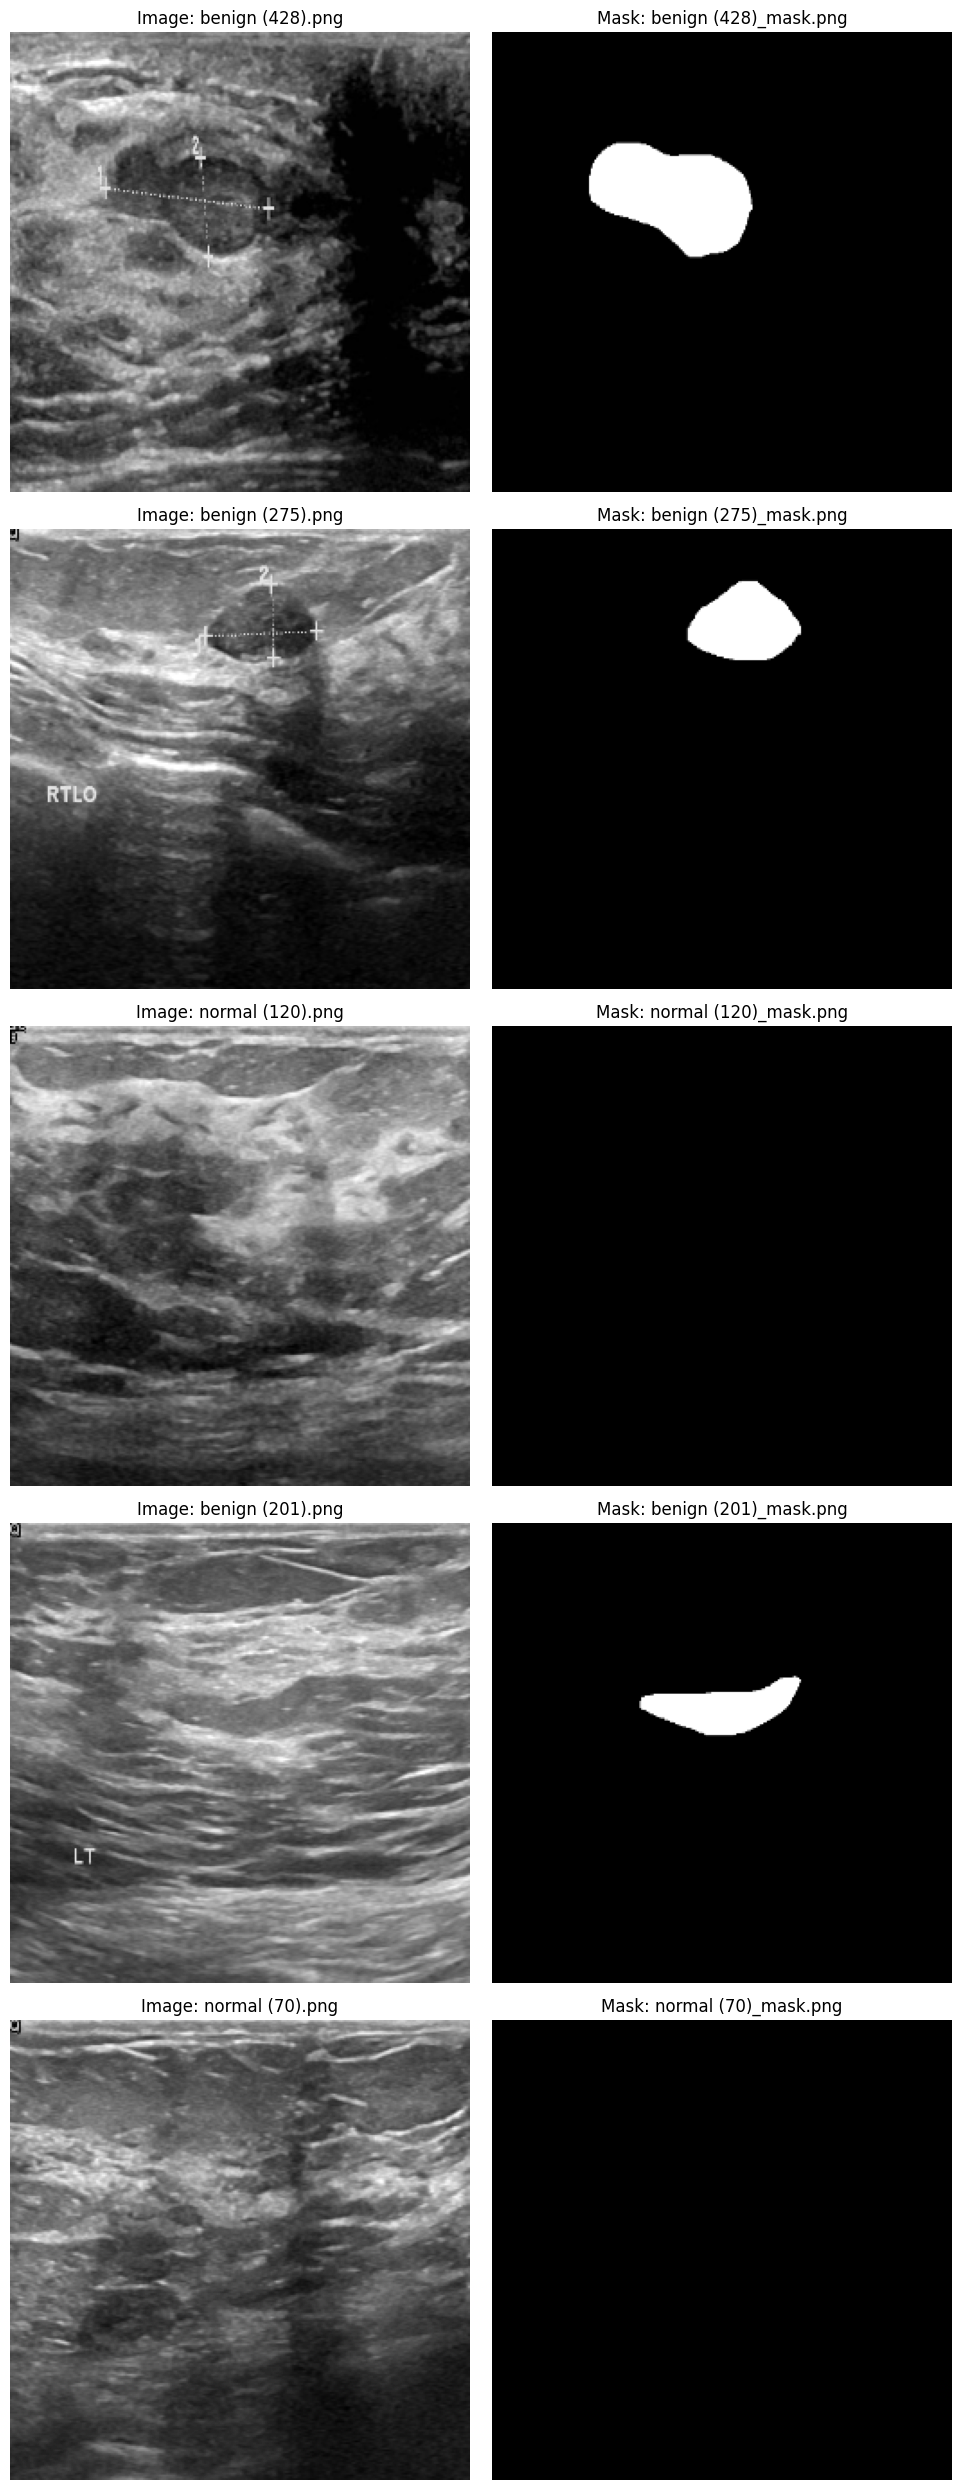

In [6]:
# Visualize some samples
visualize_samples(images, masks, filenames)

In [7]:
# Function to preprocess the images
def preprocess_images(images, masks):
    images = images.astype('float32') / 255.0
    masks = masks.astype('float32') / 255.0
    masks = np.expand_dims(masks, axis=-1)
    return np.expand_dims(images, axis=-1), masks

In [8]:
images, masks = preprocess_images(images, masks)

# U-Net Model Architecture

In [9]:
# U-Net Model Architecture
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)

    return model

In [10]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


# Compile and train the U-Net model

In [11]:
# Compile and train the U-Net model
input_size = (image_size, image_size, 1)
model = unet_model(input_size)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_val, y_val))



2024-07-26 17:25:34.925926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-26 17:25:34.961982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-26 17:25:34.962286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2024-07-26 17:25:46.010153: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.00MiB (rounded to 18874368)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-26 17:25:46.010206: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-07-26 17:25:46.010220: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 24, Chunks in use: 24. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 616B client-requested in use in bin.
2024-07-26 17:25:46.010230: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2024-07-26 17:25:46.010237: I tensorflow/tsl/framework/bfc_allocator

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [ ]:
# # Save the trained model
# model.save('unet_mammogram_segmentation.h5')

# Save model architecture to JSON
model_json = model.to_json()
with open("unet_mammogram_model.json", "w") as json_file:
    json_file.write(model_json)

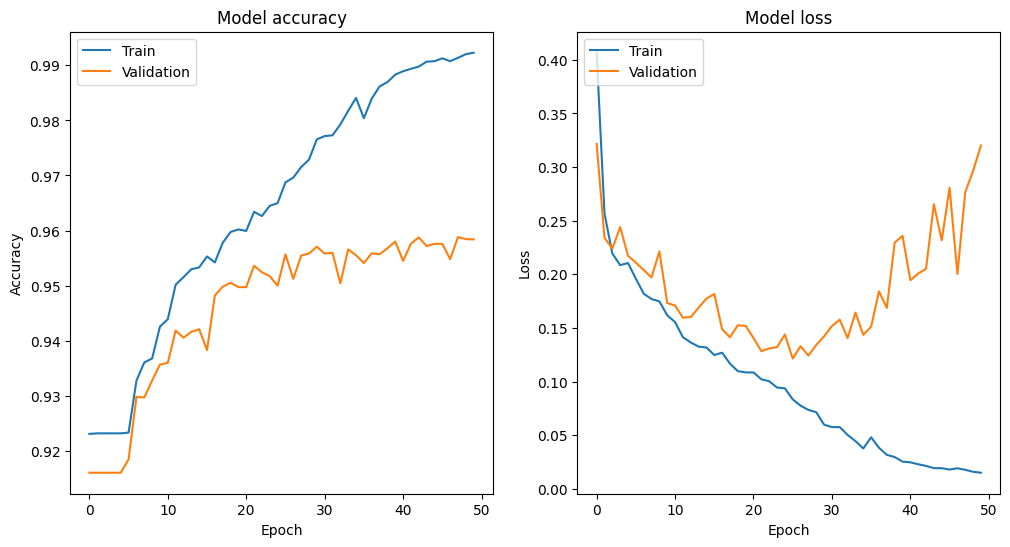

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Visualize some predictions
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0  # Check if any mask is present in the ground truth

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Prediction')

    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Binary Prediction')

    plt.show()

5/5 [==============================] - 13s 2s/step


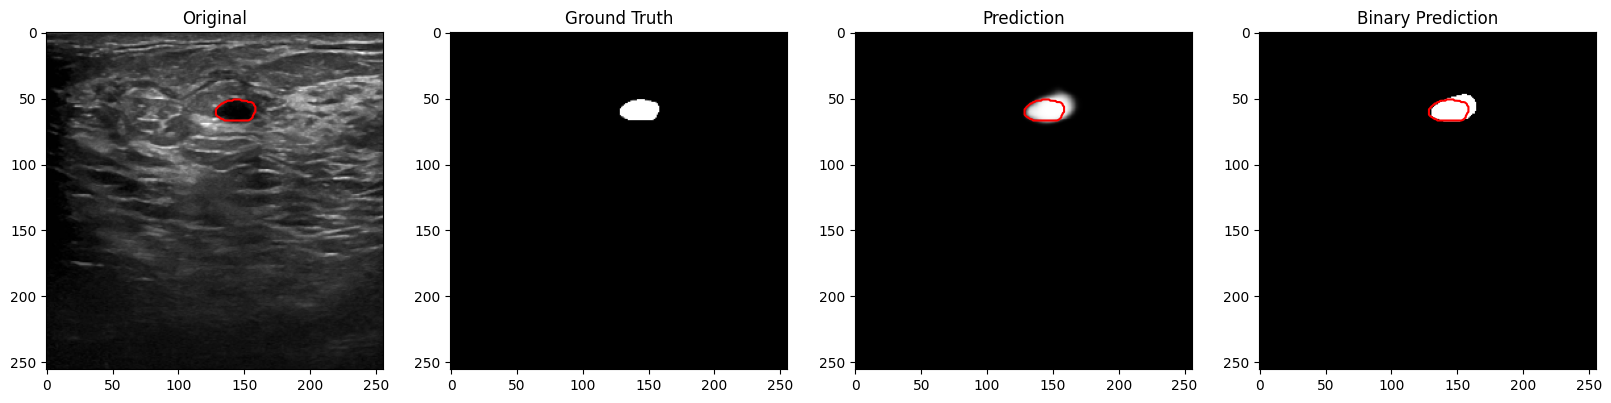

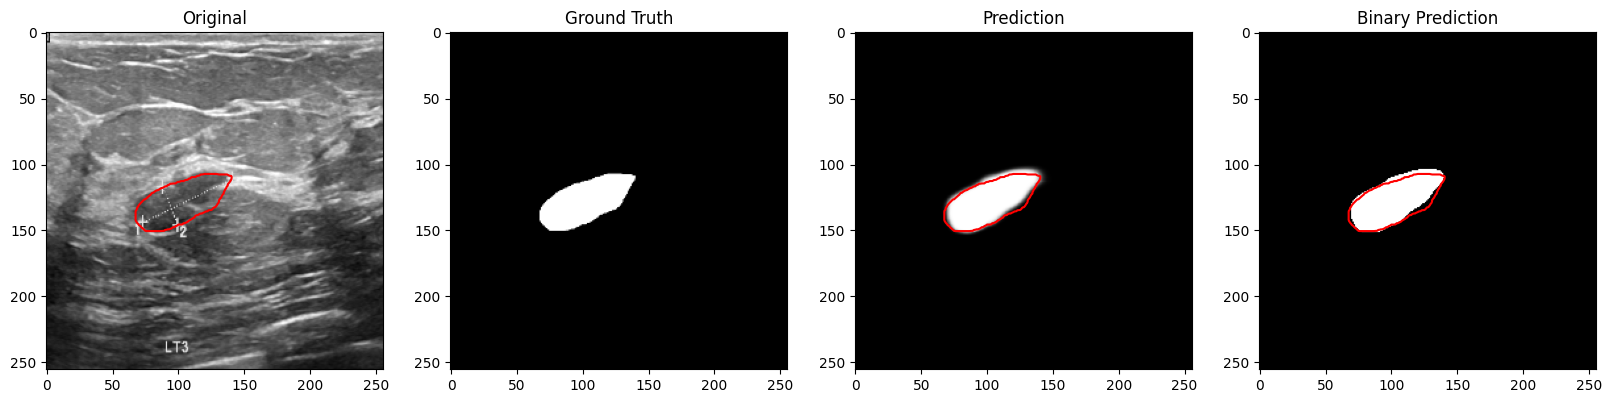

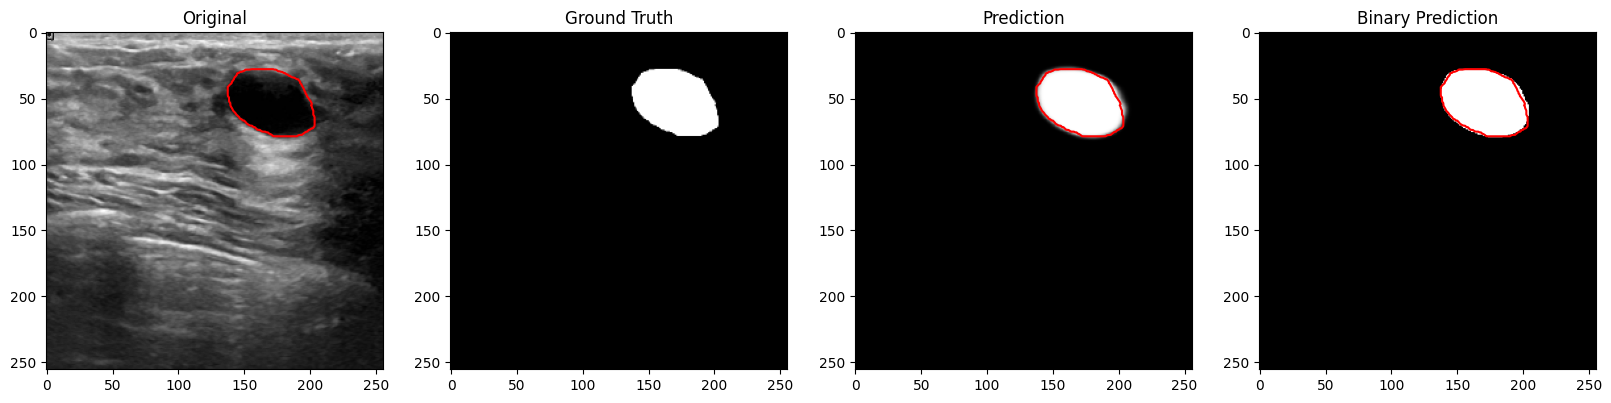

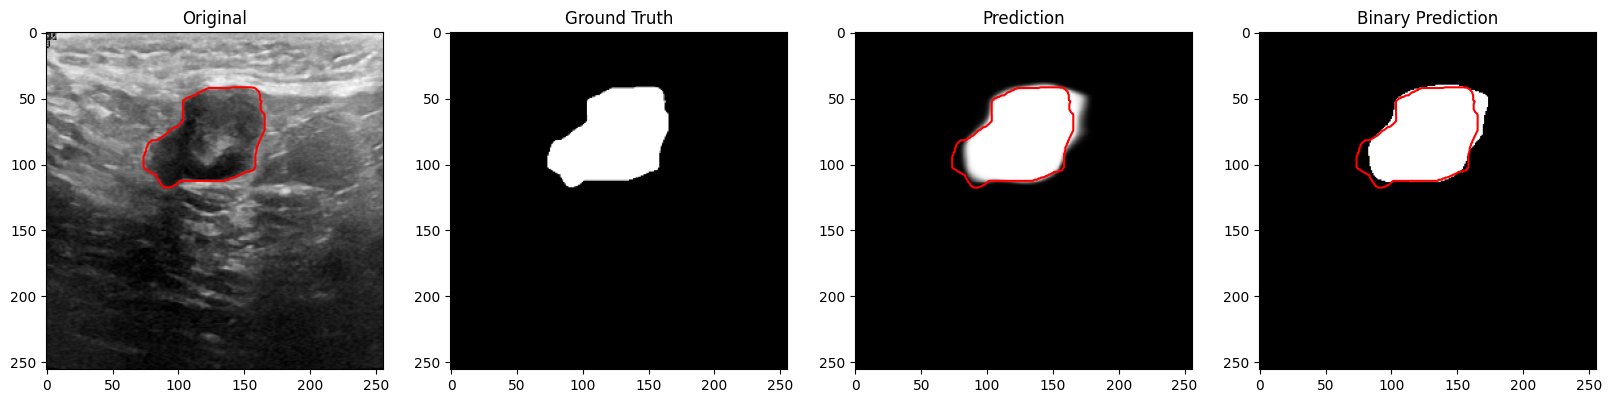

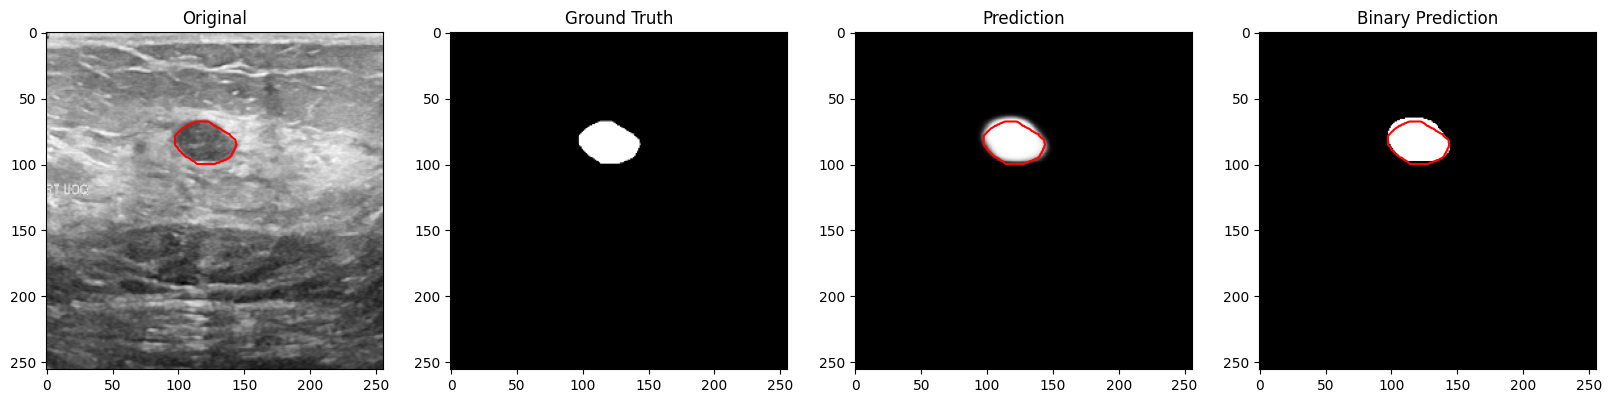

In [ ]:
# Predict on the validation set and visualize results
preds_val = model.predict(X_val, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Plot some examples
for i in range(5):
    plot_sample(X_val, y_val, preds_val, preds_val_t)